Downloading the data

In [7]:
#  Phase 1: IMDB Review Data Prep
import os
import tarfile
import urllib.request
import shutil

#Define source link and archive label
data_link = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
archive_name = "reviews_raw_archive.tar.gz"

#Fetch the archive if missing
urllib.request.urlretrieve(data_link, archive_name)

#Unzip the downloaded archive
if archive_name.endswith("tar.gz"):
    with tarfile.open(archive_name, "r:gz") as unpack:
        unpack.extractall()

#Delete unwanted data directory (unlabeled samples)
trash_path = os.path.join("aclImdb", "train", "unsup")
if os.path.isdir(trash_path):
    shutil.rmtree(trash_path)

print("Review data downloaded, unpacked, and cleaned up!")

Review data downloaded, unpacked, and cleaned up!


In [2]:
#!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
#!tar -xf aclImdb_v1.tar.gz
#!rm -r aclImdb/train/unsup

Preparing the data

In [3]:
import os, pathlib, shutil, random
from tensorflow import keras

#Define batch size and directory paths
chunk_size = 32
root_path = pathlib.Path("aclImdb")
validation_path = root_path / "val"
training_path = root_path / "train"

#Create validation directories and redistribute 20% data from train
for label in ("neg", "pos"):
    os.makedirs(validation_path / label, exist_ok=True)
    content_files = os.listdir(training_path / label)
    random.Random(1337).shuffle(content_files)
    split_count = int(0.2 * len(content_files))
    move_to_val = content_files[-split_count:]
    for document in move_to_val:
        shutil.move(training_path / label / document,
                    validation_path / label / document)

#Build TensorFlow datasets from the folders
review_train = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=chunk_size
)
review_valid = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=chunk_size
)
review_test = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=chunk_size
)

#Text-only version of training set
train_text_stream = review_train.map(lambda text, label: text)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### Base Model

Preparing integer sequence datasets

In [4]:
from tensorflow.keras import layers

#Define vectorization settings
seq_limit = 600
vocab_limit = 20000

token_encoder = layers.TextVectorization(
    max_tokens=vocab_limit,
    output_mode="int",
    output_sequence_length=seq_limit,
)

#Fit the vectorizer on raw training text
token_encoder.adapt(train_text_stream)

#Transform datasets to integer sequences
train_encoded = review_train.map(
    lambda text, label: (token_encoder(text), label),
    num_parallel_calls=4)

val_encoded = review_valid.map(
    lambda text, label: (token_encoder(text), label),
    num_parallel_calls=4)

test_encoded = review_test.map(
    lambda text, label: (token_encoder(text), label),
    num_parallel_calls=4)

A sequence model built on one-hot encoded vector sequences

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

#Vocabulary cap
vocab_size = 20000

#Model architecture
entry = tf.keras.Input(shape=(None,), dtype="int64")

#Word embeddings
word_embed = layers.Embedding(input_dim=vocab_size, output_dim=128)(entry)

#Bidirectional LSTM layer
sequence_flow = layers.Bidirectional(layers.LSTM(32))(word_embed)

#Regularization
sequence_flow = layers.Dropout(0.5)(sequence_flow)

#Output unit
prediction = layers.Dense(1, activation="sigmoid")(sequence_flow)

#Build and compile model
sentiment_net = tf.keras.Model(entry, prediction)
sentiment_net.compile(optimizer="rmsprop",
                      loss="binary_crossentropy",
                      metrics=["accuracy"])
sentiment_net.summary()

Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer (InputLayer)             ‚îÇ (None, None)                ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding (Embedding)                ‚îÇ (None, None, 128)           ‚îÇ       2,560,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional (Bidirectional)        ‚îÇ (None, 64)                  ‚îÇ          41,216 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)                    ‚îÇ (None, 64)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                        ‚îÇ (None, 1)                   ‚îÇ              65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 2,601,281 (9.92 MB)

 Trainable params: 2,601,281 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

Training a first basic sequence model

In [6]:
#Save best model using checkpoint
monitoring_tools = [
    keras.callbacks.ModelCheckpoint("lstm_best_model.keras", save_best_only=True)
]

#Train the model
training_trace = sentiment_net.fit(
    train_encoded,
    validation_data=val_encoded,
    epochs=10,
    callbacks=monitoring_tools
)

#Reload the best-performing version
best_model = keras.models.load_model("lstm_best_model.keras")

#Final evaluation on test set
final_accuracy = best_model.evaluate(test_encoded)[1]
print(f"Final Test Accuracy: {final_accuracy:.3f}")

Epoch 1/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 29s 40ms/step - accuracy: 0.6356 - loss: 0.6205 - val_accuracy: 0.7774 - val_loss: 0.4792
Epoch 2/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 39s 40ms/step - accuracy: 0.8298 - loss: 0.4222 - val_accuracy: 0.8572 - val_loss: 0.3393
Epoch 3/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 39ms/step - accuracy: 0.8753 - loss: 0.3330 - val_accuracy: 0.8302 - val_loss: 0.3778
Epoch 4/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 39ms/step - accuracy: 0.8990 - loss: 0.2813 - val_accuracy: 0.8734 - val_loss: 0.3316
Epoch 5/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 39ms/step - accuracy: 0.9147 - loss: 0.2485 - val_accuracy: 0.8566 - val_loss: 0.4376
Epoch 6/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 39ms/step - accuracy: 0.9224 - loss: 0.2252 - val_accuracy: 0.8552

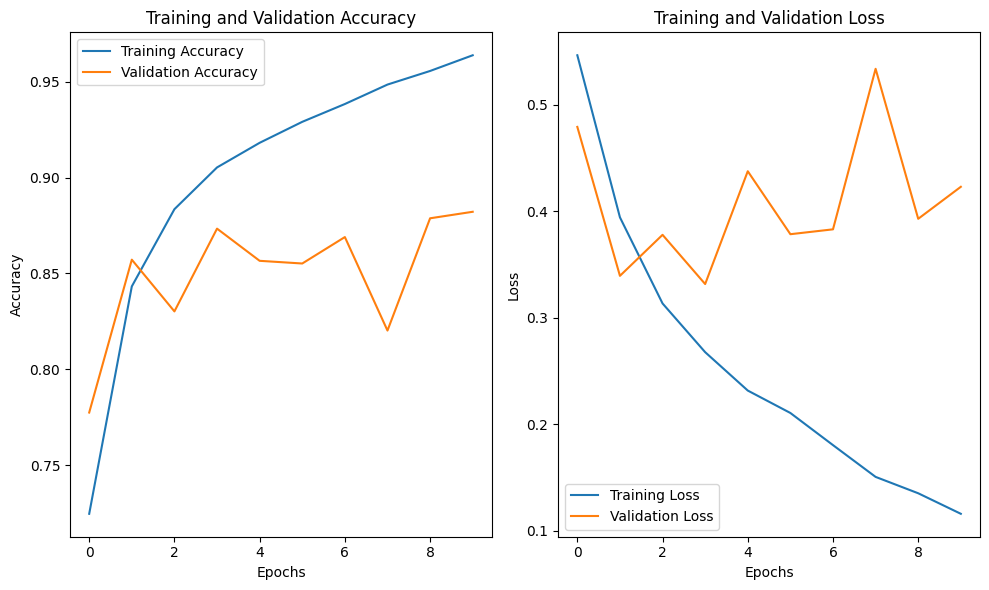

In [8]:
import matplotlib.pyplot as plt

#Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

#Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(training_trace.history['accuracy'], label='Training Accuracy')
plt.plot(training_trace.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_trace.history['loss'], label='Training Loss')
plt.plot(training_trace.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 1

In [9]:
from tensorflow.keras import layers

# Define max_tokens here
max_tokens = 20000
review_cap = 150

# Limit each review to 150 tokens
clip_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=review_cap,  # Truncate or pad to 150 tokens
)
clip_vectorizer.adapt(train_text_stream)

# Prepare encoded datasets with 150-word limit
train_150 = review_train.map(lambda x, y: (clip_vectorizer(x), y), num_parallel_calls=4)
val_150 = review_valid.map(lambda x, y: (clip_vectorizer(x), y), num_parallel_calls=4)
test_150 = review_test.map(lambda x, y: (clip_vectorizer(x), y), num_parallel_calls=4)

# Build the model with adjusted sequence length
cutoff_model = tf.keras.Sequential([
    layers.Embedding(input_dim=max_tokens, output_dim=128, input_length=review_cap),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
cutoff_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Save best-performing checkpoint
save_top = keras.callbacks.ModelCheckpoint("trimmed_bidir_lstm.keras", save_best_only=True)

# Train the model
history_trimmed = cutoff_model.fit(
    train_150,
    validation_data=val_150,
    epochs=10,
    callbacks=[save_top]
)

# Final evaluation
final_score = cutoff_model.evaluate(test_150)[1]
print(f"Test Accuracy (150 tokens): {final_score:.3f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 18ms/step - accuracy: 0.6256 - loss: 0.6274 - val_accuracy: 0.8266 - val_loss: 0.3978
Epoch 2/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 18ms/step - accuracy: 0.8290 - loss: 0.4149 - val_accuracy: 0.8554 - val_loss: 0.3448
Epoch 3/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 16ms/step - accuracy: 0.8735 - loss: 0.3263 - val_accuracy: 0.7980 - val_loss: 0.5118
Epoch 4/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 17ms/step - accuracy: 0.8976 - loss: 0.2713 - val_accuracy: 0.8488 - val_loss: 0.3923
Epoch 5/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 17ms/step - accuracy: 0.9167 - loss: 0.2292 - val_accuracy: 0.8536 - val_loss: 0.4064
Epoch 6/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 18ms/step - accuracy: 0.9345 - loss: 0.1896 - val_accuracy: 0.8598 - val_loss

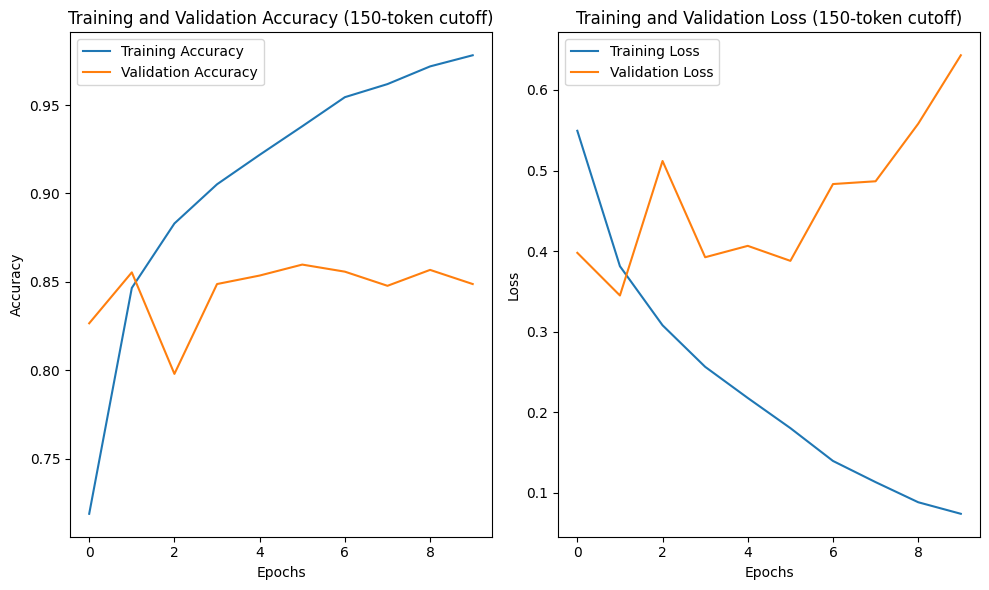

In [10]:
import matplotlib.pyplot as plt

# Plotting accuracy and loss from history_trimmed
plt.figure(figsize=(10, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_trimmed.history['accuracy'], label='Training Accuracy')
plt.plot(history_trimmed.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (150-token cutoff)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_trimmed.history['loss'], label='Training Loss')
plt.plot(history_trimmed.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (150-token cutoff)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 2

In [11]:
# Restrict training data to only 100 samples
tiny_train_ds = train_encoded.take(100)

# Define a compact LSTM model
mini_lstm_model = tf.keras.Sequential([
    layers.Embedding(input_dim=max_tokens, output_dim=128, input_length=seq_limit),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

# Compile the model
mini_lstm_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model and store history
tiny_history = mini_lstm_model.fit(
    tiny_train_ds,
    validation_data=val_encoded,
    epochs=10
)

# Evaluate on test set
tiny_test_score = mini_lstm_model.evaluate(test_encoded)[1]
print(f"Test Accuracy with 100 samples: {tiny_test_score:.3f}")

Epoch 1/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 70ms/step - accuracy: 0.4951 - loss: 0.6948 - val_accuracy: 0.5336 - val_loss: 0.6897
Epoch 2/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 91ms/step - accuracy: 0.5774 - loss: 0.6723 - val_accuracy: 0.6830 - val_loss: 0.6111
Epoch 3/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 61ms/step - accuracy: 0.7324 - loss: 0.5607 - val_accuracy: 0.7390 - val_loss: 0.5393
Epoch 4/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 65ms/step - accuracy: 0.8217 - loss: 0.4328 - val_accuracy: 0.7946 - val_loss: 0.4597
Epoch 5/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 58ms/step - accuracy: 0.8722 - loss: 0.3382 - val_accuracy: 0.7814 - val_loss: 0.4951
Epoch 6/10
100/100 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 88ms/step - accuracy: 0.9034 - loss: 0.2628 - val_accuracy: 0.7936 - val

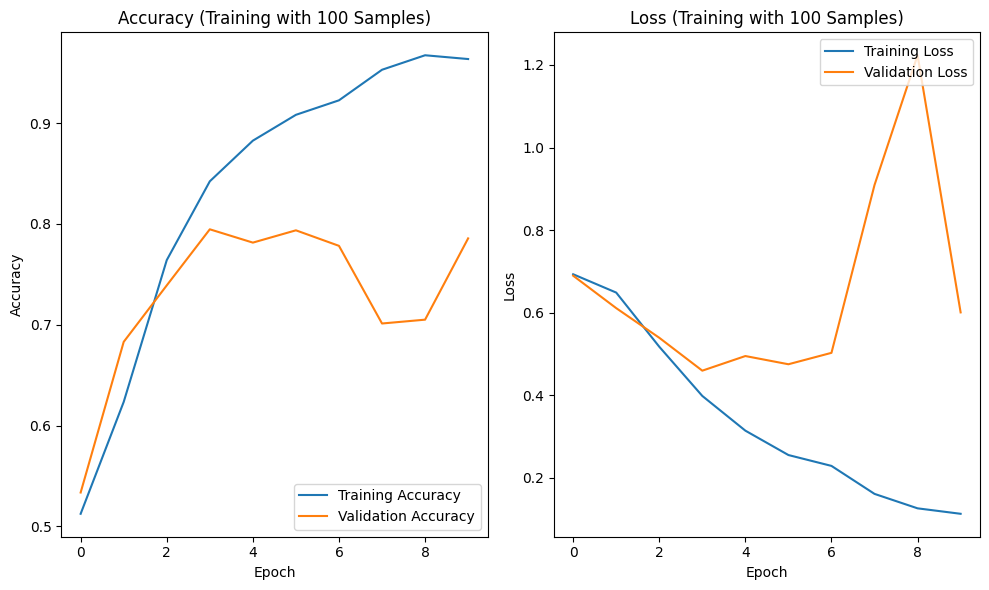

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation metrics for 100-sample experiment
plt.figure(figsize=(10, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(tiny_history.history['accuracy'], label='Training Accuracy')
plt.plot(tiny_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (Training with 100 Samples)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(tiny_history.history['loss'], label='Training Loss')
plt.plot(tiny_history.history['val_loss'], label='Validation Loss')
plt.title('Loss (Training with 100 Samples)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

### Question 3

In [13]:
# Limit validation dataset to 10,000 samples and train the model
val_encoded_10k = val_encoded.take(10000)

model_validate_10k = tf.keras.Sequential([
    layers.Embedding(vocab_limit, 128, input_length=seq_limit),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

model_validate_10k.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

history_validate_10k = model_validate_10k.fit(
    train_encoded,
    validation_data=val_encoded_10k,
    epochs=10
)

print(f"Test acc: {model_validate_10k.evaluate(test_encoded)[1]:.3f}")

Epoch 1/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 40ms/step - accuracy: 0.6114 - loss: 0.6336 - val_accuracy: 0.8056 - val_loss: 0.4488
Epoch 2/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 25s 40ms/step - accuracy: 0.8390 - loss: 0.4013 - val_accuracy: 0.8596 - val_loss: 0.3366
Epoch 3/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 39ms/step - accuracy: 0.8726 - loss: 0.3300 - val_accuracy: 0.8498 - val_loss: 0.3822
Epoch 4/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26s 42ms/step - accuracy: 0.8982 - loss: 0.2800 - val_accuracy: 0.8758 - val_loss: 0.3036
Epoch 5/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 40ms/step - accuracy: 0.9163 - loss: 0.2359 - val_accuracy: 0.8822 - val_loss: 0.3392
Epoch 6/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 40ms/step - accuracy: 0.9269 - loss: 0.2057 - val_accuracy: 0.8714

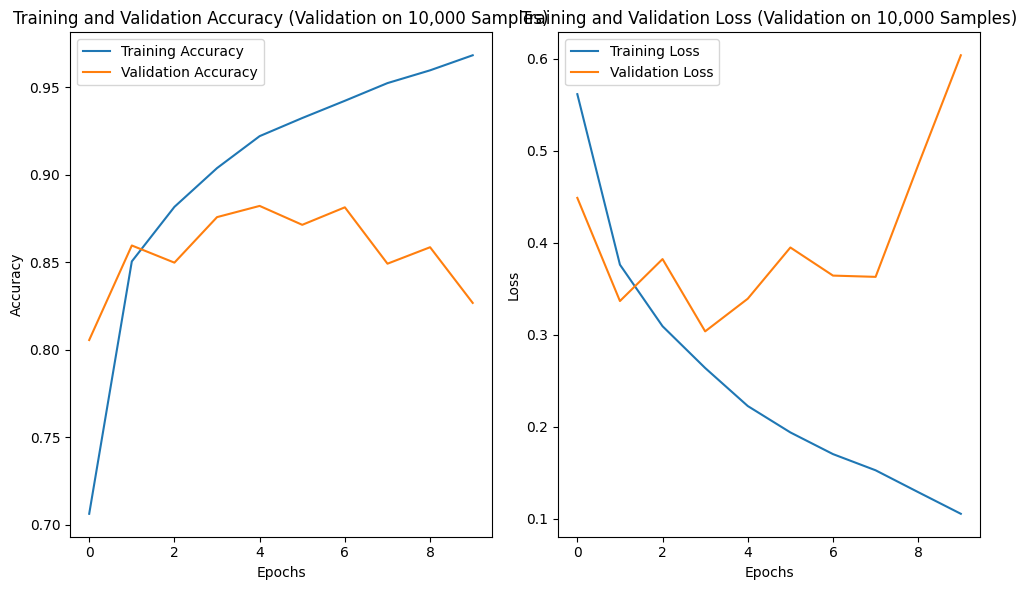

In [14]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_validate_10k.history['accuracy'], label='Training Accuracy')
plt.plot(history_validate_10k.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Validation on 10,000 Samples)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_validate_10k.history['loss'], label='Training Loss')
plt.plot(history_validate_10k.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Validation on 10,000 Samples)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 4

In [15]:
# Adjust max_tokens to 10,000 and train the model
max_tokens_10k = 10000

text_vectorization_10k = layers.TextVectorization(
    max_tokens=max_tokens_10k,
    output_mode="int",
    output_sequence_length=seq_limit,  # fixed here
)
text_vectorization_10k.adapt(train_text_stream)

int_train_ds_10k = review_train.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)

int_val_ds_10k = review_valid.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)

int_test_ds_10k = review_test.map(
    lambda x, y: (text_vectorization_10k(x), y),
    num_parallel_calls=4)

model_top_10k = tf.keras.Sequential([
    layers.Embedding(max_tokens_10k, 128, input_length=seq_limit),  # also fixed
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid"),
])

model_top_10k.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

history_top_10k = model_top_10k.fit(
    int_train_ds_10k,
    validation_data=int_val_ds_10k,
    epochs=10
)

print(f"Test acc: {model_top_10k.evaluate(int_test_ds_10k)[1]:.3f}")

Epoch 1/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 39ms/step - accuracy: 0.6104 - loss: 0.6334 - val_accuracy: 0.8394 - val_loss: 0.4057
Epoch 2/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 39ms/step - accuracy: 0.8300 - loss: 0.4185 - val_accuracy: 0.8524 - val_loss: 0.3533
Epoch 3/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44s 44ms/step - accuracy: 0.8546 - loss: 0.3715 - val_accuracy: 0.8498 - val_loss: 0.3496
Epoch 4/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 38s 39ms/step - accuracy: 0.8813 - loss: 0.3123 - val_accuracy: 0.8838 - val_loss: 0.3059
Epoch 5/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 39ms/step - accuracy: 0.8973 - loss: 0.2846 - val_accuracy: 0.8726 - val_loss: 0.3237
Epoch 6/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 40ms/step - accuracy: 0.9138 - loss: 0.2444 - val_accuracy: 0.8750

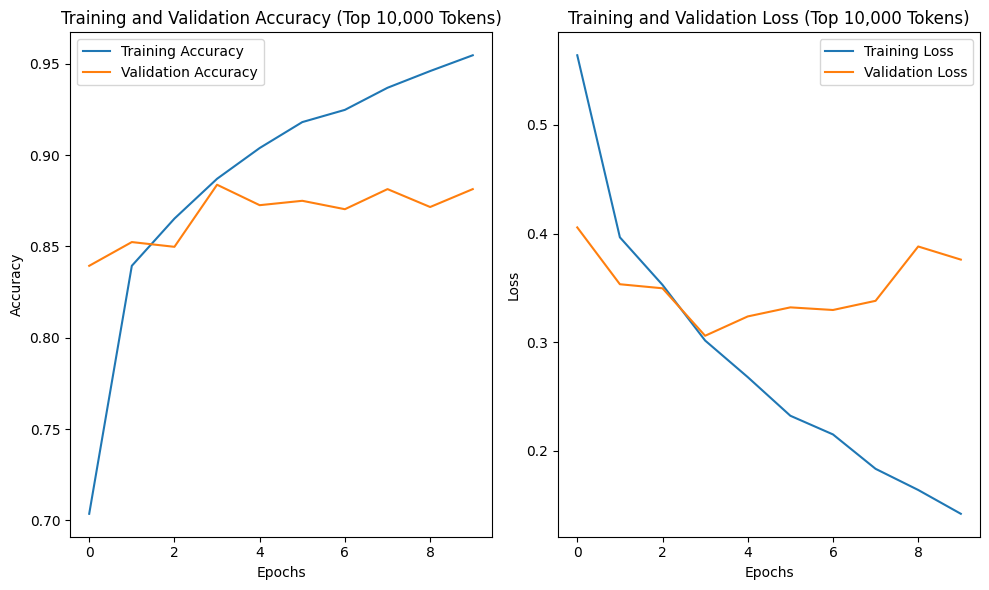

In [16]:
# Plotting the training and validation accuracy for top 10,000 tokens model
plt.figure(figsize=(10, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_top_10k.history['accuracy'], label='Training Accuracy')
plt.plot(history_top_10k.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Top 10,000 Tokens)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_top_10k.history['loss'], label='Training Loss')
plt.plot(history_top_10k.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Top 10,000 Tokens)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Question 5

In [18]:
import urllib.request
import zipfile
import os

# Download GloVe zip if not already downloaded
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"

if not os.path.exists(glove_zip):
    print("Downloading GloVe...")
    urllib.request.urlretrieve(glove_url, glove_zip)

# Extract glove.6B.100d.txt
if not os.path.exists("glove.6B.100d.txt"):
    print("Extracting glove.6B.100d.txt...")
    with zipfile.ZipFile(glove_zip, "r") as zip_ref:
        zip_ref.extract("glove.6B.100d.txt")

print("GloVe ready.")

üì¶ Extracting glove.6B.100d.txt...
GloVe ready.


Preparing pre trained model

In [20]:
import os
import tarfile
import urllib.request
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers

# Step 1: Download and extract dataset
imdb_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
archive_path = "acl_data.tar.gz"
urllib.request.urlretrieve(imdb_url, archive_path)

if archive_path.endswith("tar.gz"):
    with tarfile.open(archive_path, "r:gz") as extracted:
        extracted.extractall()

# Step 2: Remove unused data
junk_path = "aclImdb/train/unsup"
if os.path.exists(junk_path):
    import shutil
    shutil.rmtree(junk_path)

print("IMDB dataset ready for use.")

# Step 3: Load GloVe embeddings
glove_file = "glove.6B.100d.txt"
glove_vectors = {}

if os.path.exists(glove_file):
    with open(glove_file, encoding="utf-8") as glove_data:
        for line in glove_data:
            term, vector_str = line.split(maxsplit=1)
            vector = np.fromstring(vector_str, dtype="float32", sep=" ")
            glove_vectors[term] = vector
    print(f"Found {len(glove_vectors)} word vectors.")
else:
    print("GloVe file missing. Download and place glove.6B.100d.txt in the current directory.")

# Step 4: Setup vocab and embedding matrix
vocab_limit = 20000
sequence_limit = 200

fake_vectorizer = layers.TextVectorization(
    max_tokens=vocab_limit,
    output_sequence_length=sequence_limit
)

# Dummy vocab example (replace this with your actual vocab in real use)
sample_words = ["film", "plot", "funny", "boring", "nice", "awful"]
token_to_index = dict(zip(sample_words, range(len(sample_words))))

vector_size = 100
pretrained_matrix = np.zeros((vocab_limit, vector_size))

for token, idx in token_to_index.items():
    if idx < vocab_limit:
        vec = glove_vectors.get(token)
        if vec is not None:
            pretrained_matrix[idx] = vec

# Step 5: Define Embedding layers
trainable_embed = layers.Embedding(
    input_dim=vocab_limit,
    output_dim=vector_size,
    input_length=sequence_limit
)

frozen_embed = layers.Embedding(
    input_dim=vocab_limit,
    output_dim=vector_size,
    embeddings_initializer=initializers.Constant(pretrained_matrix),
    trainable=False,
    mask_zero=True
)

print("Embedding layers initialized and ready.")

IMDB dataset ready for use.
Found 400000 word vectors.
Embedding layers initialized and ready.


In [25]:
# Vectorize the datasets using your token_encoder (TextVectorization layer)
int_train_ds = review_train.map(lambda x, y: (token_encoder(x), y), num_parallel_calls=4)
int_val_ds = review_valid.map(lambda x, y: (token_encoder(x), y), num_parallel_calls=4)
int_test_ds = review_test.map(lambda x, y: (token_encoder(x), y), num_parallel_calls=4)

In [26]:
# Ensure these variables are defined before running this cell:
embedding_dim = 100
vocab_limit = 20000
seq_limit = 600

# Define a new trainable embedding layer
learned_embed_layer = layers.Embedding(
    input_dim=vocab_limit,
    output_dim=embedding_dim,
    input_length=seq_limit
)

# Define the model using the learned embedding layer
input_tensor = tf.keras.Input(shape=(None,), dtype="int64")
x = learned_embed_layer(input_tensor)
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.5)(x)
output_tensor = layers.Dense(1, activation="sigmoid")(x)

model_learned_embed = tf.keras.Model(input_tensor, output_tensor)
model_learned_embed.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

# Make sure int_train_ds, int_val_ds, int_test_ds are available from earlier vectorization
history_learned_embed = model_learned_embed.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10
)

# Evaluate on the test dataset
print(f"Test acc (Trained Embedding): {model_learned_embed.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 40ms/step - accuracy: 0.6186 - loss: 0.6254 - val_accuracy: 0.8296 - val_loss: 0.4216
Epoch 2/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24s 39ms/step - accuracy: 0.8286 - loss: 0.4276 - val_accuracy: 0.8758 - val_loss: 0.3138
Epoch 3/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 39ms/step - accuracy: 0.8716 - loss: 0.3373 - val_accuracy: 0.8660 - val_loss: 0.3574
Epoch 4/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24s 39ms/step - accuracy: 0.8975 - loss: 0.2896 - val_accuracy: 0.8700 - val_loss: 0.3326
Epoch 5/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 39ms/step - accuracy: 0.9149 - loss: 0.2483 - val_accuracy: 0.8432 - val_loss: 0.3424
Epoch 6/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 39ms/step - accuracy: 0.9263 - loss: 0.2198 - val_accuracy: 0.8722

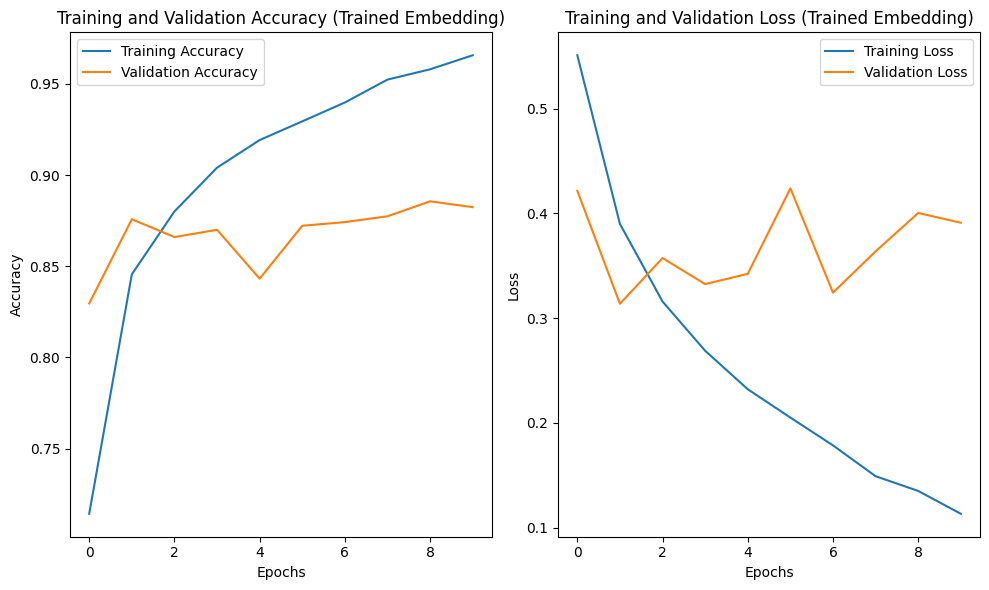

In [28]:
# Plotting the training and validation accuracy/loss for the learned embedding model
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_learned_embed.history['accuracy'], label='Training Accuracy')
plt.plot(history_learned_embed.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Trained Embedding)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_learned_embed.history['loss'], label='Training Loss')
plt.plot(history_learned_embed.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Trained Embedding)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
import requests
import zipfile
import os
import numpy as np

# Step 1: Download GloVe zip file
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"
glove_txt = "glove.6B.100d.txt"

if not os.path.exists(glove_txt):
    print("Downloading GloVe embeddings...")
    response = requests.get(glove_url)
    with open(glove_zip, "wb") as file:
        file.write(response.content)

    print("Extracting GloVe files...")
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extractall(".")

    os.remove(glove_zip)  # Optional cleanup
    print("GloVe download and extraction complete.")
else:
    print("GloVe file already exists.")

# Step 2: Load glove.6B.100d.txt into a dictionary
embeddings_index = {}
try:
    print("Loading GloVe word vectors into dictionary...")
    with open(glove_txt, encoding="utf-8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors.")
except FileNotFoundError:
    print(f"File not found: {glove_txt}")
except Exception as e:
    print(f"Error while loading GloVe: {e}")

GloVe file already exists.
Loading GloVe word vectors into dictionary...
Found 400000 word vectors.


In [33]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np

# Parameters
vocab_limit = 20000
embedding_dim = 100
seq_limit = 600
batch_size = 32

# Step 1: Load GloVe embeddings
glove_path = "glove.6B.100d.txt"
glove_vectors = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_vectors[word] = coefs
print(f"Found {len(glove_vectors)} word vectors.")

# Step 2: Load dataset
review_train = keras.utils.text_dataset_from_directory("aclImdb/train", batch_size=batch_size)
review_valid = keras.utils.text_dataset_from_directory("aclImdb/val", batch_size=batch_size)
review_test = keras.utils.text_dataset_from_directory("aclImdb/test", batch_size=batch_size)

# Step 3: Vectorization layer
train_text_stream = review_train.map(lambda text, label: text)
token_encoder = layers.TextVectorization(max_tokens=vocab_limit, output_sequence_length=seq_limit)
token_encoder.adapt(train_text_stream)

# Step 4: Create embedding matrix from GloVe
vocab = token_encoder.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((vocab_limit, embedding_dim))
for word, i in word_index.items():
    if i < vocab_limit:
        vector = glove_vectors.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# Step 5: Define the frozen embedding layer
frozen_embed = layers.Embedding(
    input_dim=vocab_limit,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)

# Step 6: Vectorize the datasets
def vectorize_data(text, label):
    return token_encoder(text), label

encoded_train = review_train.map(vectorize_data).cache().prefetch(tf.data.AUTOTUNE)
encoded_valid = review_valid.map(vectorize_data).cache().prefetch(tf.data.AUTOTUNE)
encoded_test = review_test.map(vectorize_data).cache().prefetch(tf.data.AUTOTUNE)

# Step 7: Build the model using GloVe embeddings
glove_input = tf.keras.Input(shape=(None,), dtype="int64")
x = frozen_embed(glove_input)
x = layers.Bidirectional(layers.LSTM(32))(x)
x = layers.Dropout(0.5)(x)
glove_output = layers.Dense(1, activation="sigmoid")(x)

glove_embed_model = tf.keras.Model(glove_input, glove_output)

# Step 8: Compile and train
glove_embed_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

glove_history = glove_embed_model.fit(
    encoded_train,
    validation_data=encoded_valid,
    epochs=10
)

# Step 9: Evaluate
glove_test_score = glove_embed_model.evaluate(encoded_test)[1]
print(f" Test Accuracy (GloVe Pretrained): {glove_test_score:.3f}")

Found 400000 word vectors.
Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Epoch 1/10
782/782 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 31s 37ms/step - accuracy: 0.6298 - loss: 0.6273 - val_accuracy: 0.7944 - val_loss: 0.4517
Epoch 2/10
782/782 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 34ms/step - accuracy: 0.7919 - loss: 0.4578 - val_accuracy: 0.8270 - val_loss: 0.3845
Epoch 3/10
782/782 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 34ms/step - accuracy: 0.8212 - loss: 0.3999 - val_accuracy: 0.8252 - val_loss: 0.3771
Epoch 4/10
782/782 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42s 35ms/step - accuracy: 0.8431 - loss: 0.3652 - val_accuracy: 0.8732 - val_loss: 0.3074
Epoch 5/10
782/782 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 34ms/step - accuracy: 0.8561 - loss: 0.3377 - val_accuracy: 0.8862 - val_loss: 0.279

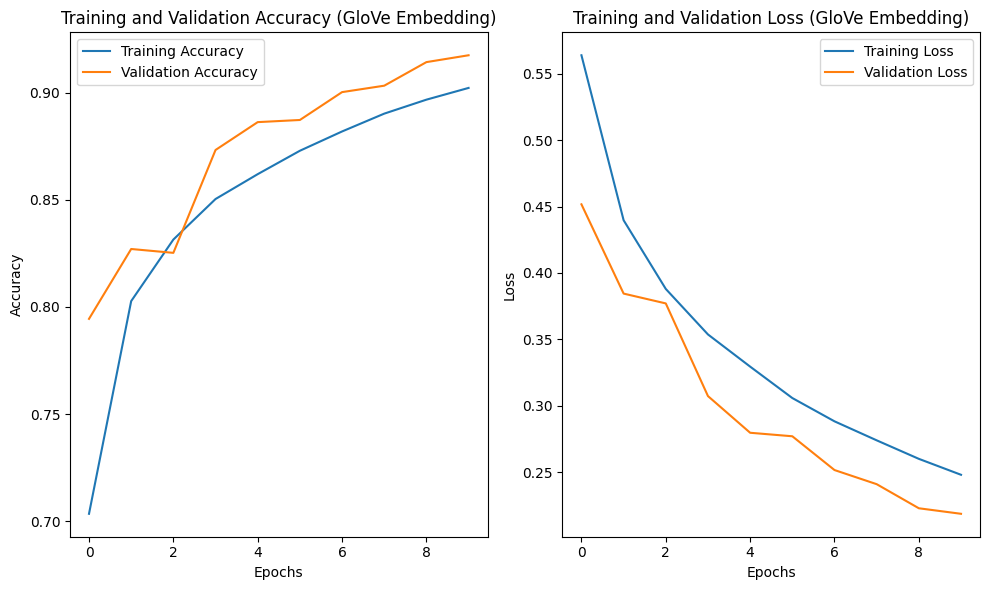

In [34]:
import matplotlib.pyplot as plt

# Plotting accuracy and loss for GloVe-based model
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(glove_history.history['accuracy'], label='Training Accuracy')
plt.plot(glove_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (GloVe Embedding)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(glove_history.history['loss'], label='Training Loss')
plt.plot(glove_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (GloVe Embedding)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


üîÅ Training with 100 samples...
‚úÖ Training Size: 100, Test Accuracy: 0.634

üîÅ Training with 500 samples...
‚úÖ Training Size: 500, Test Accuracy: 0.772

üîÅ Training with 1000 samples...
‚úÖ Training Size: 1000, Test Accuracy: 0.778

üîÅ Training with 5000 samples...
‚úÖ Training Size: 5000, Test Accuracy: 0.786

üîÅ Training with 625 samples...
‚úÖ Training Size: 625, Test Accuracy: 0.790

üìä Final Test Accuracies:
Training Size: 100, Test Accuracy: 0.634
Training Size: 500, Test Accuracy: 0.772
Training Size: 1000, Test Accuracy: 0.778
Training Size: 5000, Test Accuracy: 0.786
Training Size: 625, Test Accuracy: 0.790


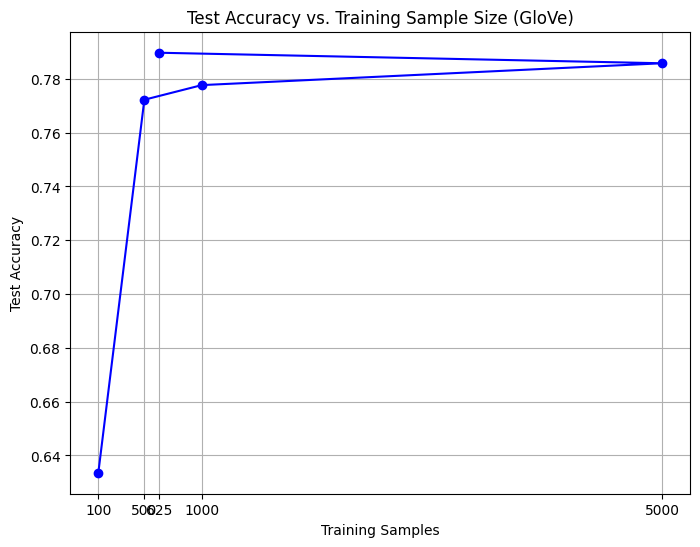

In [35]:
import matplotlib.pyplot as plt

# Define different training sample sizes
sample_sizes = [100, 500, 1000, 5000, len(list(int_train_ds))]

# Store test accuracies
test_acc_vs_size = []

for size in sample_sizes:
    # Limit the training dataset
    partial_train_ds = int_train_ds.take(size)

    # Define model with frozen GloVe embedding
    sample_input = tf.keras.Input(shape=(None,), dtype="int64")
    x = frozen_embed(sample_input)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dropout(0.5)(x)
    sample_output = layers.Dense(1, activation="sigmoid")(x)

    sample_model = tf.keras.Model(sample_input, sample_output)
    sample_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

    # Train on subset
    print(f"\n Training with {size} samples...")
    sample_model.fit(partial_train_ds, validation_data=int_val_ds, epochs=10, verbose=0)

    # Evaluate
    acc = sample_model.evaluate(int_test_ds, verbose=0)[1]
    test_acc_vs_size.append(acc)
    print(f"Training Size: {size}, Test Accuracy: {acc:.3f}")

# Print final results
print("\n Final Test Accuracies:")
for s, a in zip(sample_sizes, test_acc_vs_size):
    print(f"Training Size: {s}, Test Accuracy: {a:.3f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, test_acc_vs_size, marker='o', linestyle='-', color='blue')
plt.title("Test Accuracy vs. Training Sample Size (GloVe)")
plt.xlabel("Training Samples")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.xticks(sample_sizes)
plt.show()